# Dataset

CIFAR 10

In [1]:
import torchvision

cifar10Train = torchvision.datasets.CIFAR10("./CIFAR10", download=True, transform=lambda im: torchvision.transforms.functional.pil_to_tensor(im)/255)
cifar10Test = torchvision.datasets.CIFAR10("./CIFAR10", train=False, download=True, transform=lambda im: torchvision.transforms.functional.pil_to_tensor(im)/255)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import PIL
from sklearn.metrics import accuracy_score, f1_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Models

## CNN1.1

3 Conv, 2 FC, No dropout, no batch norm

Activation fn: ReLU

Optimizer: SGD with momentum

In [3]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn1 = nn.Conv2d(3, 16, (3, 3), padding='same').to(device)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=(2, 2)).to(device)

        self.cnn2 = nn.Conv2d(16, 32, (3, 3), padding='same').to(device)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2, 2), stride=(2,2)).to(device)

        self.cnn3 = nn.Conv2d(32, 64, (3, 3), padding='same').to(device)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d((2, 2), stride=(2,2)).to(device)

        self.linear1 = nn.Linear(64 * 4 * 4, 512)
        self.relu4 = nn.ReLU()

        self.linear2 = nn.Linear(512, 512)
        self.relu5 = nn.ReLU()

        self.linear3 = nn.Linear(512, 10)

    def forward(self, inputs):
        x = self.cnn1(inputs)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = torch.flatten(x, 1)

        x = self.linear1(x)
        x = self.relu4(x)

        x = self.linear2(x)
        x = self.relu5(x)

        x = self.linear3(x)
    
        return x


In [16]:
trainloader = DataLoader(cifar10Train, 64)
testloader = DataLoader(cifar10Test, 64)

In [21]:
def train_one_epoch(model, optimzer, loss_fn, training_loader, track_momentum=False):
    running_loss = 0.
    running_momentum = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))

        loss = loss_fn(outputs, labels.to(device))
        loss.backward()

        optimizer.step()
        if track_momentum:
            temp = 0
            for j in range(len(optimizer.state)):
                temp += torch.mean(list(optimizer.state.values())[j]['momentum_buffer']).item()
            running_momentum += temp/j

        running_loss += loss.item()

        
    average_loss = running_loss/(i+1)
    
    if track_momentum:
        return average_loss, running_momentum/(i+1)

    return average_loss

In [18]:
def evaluate(tdataset, model):
    preds = []
    truths = []
    for example in tdataset:
        input = example[0].unsqueeze(0).to(device)
        logits = model(input)
        pred = torch.argmax(torch.softmax(logits, 1))
        preds.append(pred.item())
        truths.append(example[1])
    return accuracy_score(truths, preds), f1_score(truths, preds, average='macro'), preds, truths

In [19]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model, filepath, device='cpu'):
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.eval()

In [22]:
cnn1 = CNN1().to(device)

optimizer = torch.optim.SGD(cnn1.parameters(), 1e-3, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [23]:
EPOCHS = 120

begin = time.time()

max_f1 = -float('inf')

log = []

for epoch in range(EPOCHS):
    cnn1.train(True)
    average_train_loss, avg_momentum = train_one_epoch(cnn1, optimizer, loss_fn, trainloader, track_momentum=True)

    cnn1.eval()
    running_test_loss = 0.
    for i, data in enumerate(testloader):
        inputs, labels = data
        outputs = cnn1(inputs.to(device))
        loss = loss_fn(outputs, labels.to(device))
        running_test_loss += loss.item()
    average_test_loss = running_test_loss/(i+1)
    end = time.time()
    log.append({'average_test_loss': average_test_loss, 'average_train_loss': average_train_loss, 'average_momentum': avg_momentum, 'time_from_start': end-begin})
    if (epoch+1)%5 == 0:
        train_accuracy, train_f1, _, _ = evaluate(cifar10Train, cnn1)
        test_accuracy, test_f1, _, _ = evaluate(cifar10Test, cnn1)
        if test_f1 > max_f1:
            max_f1 = test_f1
            save_model(cnn1, './models/cnn1-1.pth')
        print(f"Epoch {epoch+1} | train loss: {average_train_loss:.3f} | train accuracy: {100*train_accuracy:.2f}% | train f1: {train_f1:.2f} | test loss: {average_test_loss:.3f} | test accuracy: {100*test_accuracy:.2f}% | test f1: {test_f1:.2f} | avg_momentum: {avg_momentum} | time: {end-begin:.2f}s")

Epoch 5 | train loss: 2.294 | train accuracy: 18.11% | train f1: 0.10 | test loss: 2.284 | test accuracy: 17.82% | test f1: 0.10 | avg_momentum: -0.0008781357316393604 | time: 51.51s
Epoch 10 | train loss: 1.757 | train accuracy: 38.27% | train f1: 0.36 | test loss: 1.683 | test accuracy: 38.83% | test f1: 0.37 | avg_momentum: -0.00017532605925480718 | time: 156.90s
Epoch 15 | train loss: 1.344 | train accuracy: 52.73% | train f1: 0.52 | test loss: 1.313 | test accuracy: 52.95% | test f1: 0.52 | avg_momentum: 0.0004872358550690589 | time: 262.37s
Epoch 20 | train loss: 1.125 | train accuracy: 61.61% | train f1: 0.61 | test loss: 1.123 | test accuracy: 60.35% | test f1: 0.60 | avg_momentum: 4.113017092042296e-05 | time: 367.74s
Epoch 25 | train loss: 0.956 | train accuracy: 68.54% | train f1: 0.69 | test loss: 1.000 | test accuracy: 65.52% | test f1: 0.66 | avg_momentum: -0.0001206449630780685 | time: 473.09s
Epoch 30 | train loss: 0.810 | train accuracy: 73.06% | train f1: 0.73 | test 

In [25]:
logdf = pd.DataFrame(log)

<Axes: >

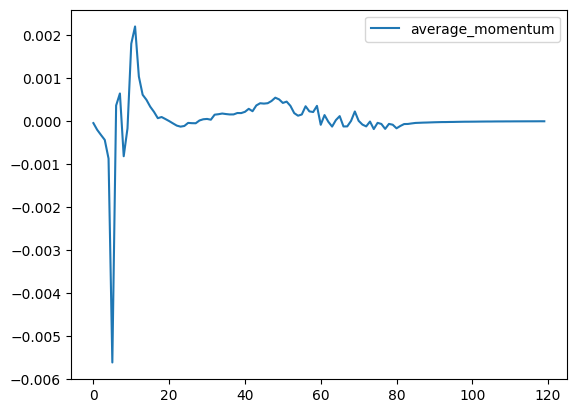

In [31]:
logdf[['average_momentum']] .plot()

In [29]:
logdf

,average_test_loss,average_train_loss,average_momentum,time_from_start
0,2.302228,2.302630,-0.000054,10.294805
1,2.301774,2.302114,-0.000210,20.606069
2,2.300966,2.301542,-0.000329,30.910170
3,2.298679,2.300209,-0.000444,41.230502
4,2.284099,2.294327,-0.000878,51.511664
...,...,...,...,...
115,2.916117,0.000272,-0.000012,2424.410713
116,2.922241,0.000266,-0.000012,2434.593510
117,2.928142,0.000260,-0.000012,2444.774677
118,2.933847,0.000254,-0.000011,2454.895148
